In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

In [52]:
data_path = "data/spotify.csv"
try:
    df = pd.read_csv(data_path)
    print("Spotify dataset loaded successfully!")
except:
    import kagglehub
    import shutil
    import os
    # Download latest version
    path = kagglehub.dataset_download("atharvasoundankar/spotify-global-streaming-data-2024")
    
    # Get the first file in path
    files = os.listdir(path)
    if len(files) == 0:
        raise ValueError("No files found in the downloaded dataset.")
    # Check if the data directory exists, if not create it
    if not os.path.exists("data"):
        os.makedirs("data")

    # Move the downloaded file to the desired directory
    shutil.move(os.path.join(path, files[0]), data_path)

    print("Spotify dataset downloaded successfully!")

Spotify dataset loaded successfully!


In [53]:
country_counts = df['Country'].value_counts()
print(country_counts)

Country
Italy             34
South Africa      32
South Korea       31
Russia            31
Brazil            30
Sweden            30
Argentina         27
Spain             25
Canada            25
Indonesia         25
Mexico            24
Japan             23
France            23
Netherlands       23
India             22
United Kingdom    22
Turkey            22
Germany           20
United States     19
Australia         12
Name: count, dtype: int64


In [54]:
unique_countries_count = df['Country'].nunique()
print(f"Anzahl einzigartiger Länder: {unique_countries_count}")

Anzahl einzigartiger Länder: 20


In [55]:
album_counts = df['Album'].value_counts().reset_index()
album_counts.columns = ['Album', 'Count']
album_counts_sorted = album_counts.sort_values(by='Count', ascending=False)
album_counts_sorted.head()

,Album,Count
0,Proof,44
1,Nadie Sabe Lo Que Va a Pasar Mañana,40
2,Future Nostalgia,37
3,BORN PINK,37
4,MAÑANA SERÁ BONITO,37


In [56]:
# Nur die wichtigsten Kategorien als Dummy-Variablen kodieren
df_encoded = pd.get_dummies(df, columns=['Country', 'Genre', 'Platform Type', 'Artist', 'Album'], drop_first=True)

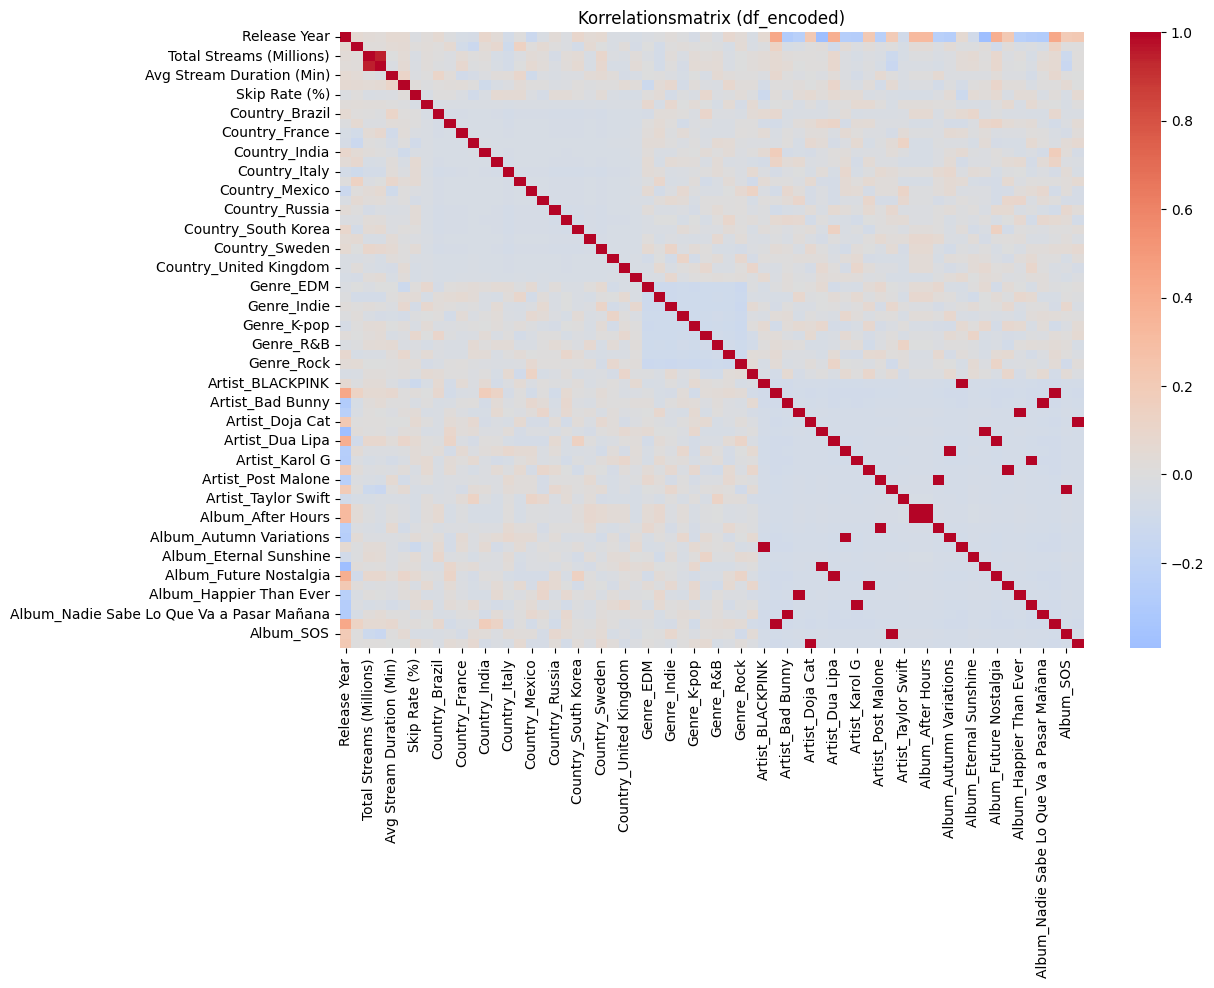

Skip Rate (%)          1.000000
Genre_Pop              0.080917
Album_Scarlet          0.057771
Artist_Doja Cat        0.057771
Country_Indonesia      0.057642
                         ...   
Country_Netherlands   -0.056265
Genre_Indie           -0.065374
Country_Germany       -0.083025
Artist_BLACKPINK      -0.115498
Album_BORN PINK       -0.115498
Name: Skip Rate (%), Length: 64, dtype: float64


In [57]:
corr_matrix = df_encoded.corr(numeric_only=True)
plt.figure(figsize=(12,8))
sns.heatmap(corr_matrix, cmap='coolwarm', center=0)
plt.title("Korrelationsmatrix (df_encoded)")
plt.show()

corr_target = corr_matrix['Skip Rate (%)'].sort_values(ascending=False)
print(corr_target)

In [58]:
X = df_encoded.drop(columns=['Skip Rate (%)'])
y = df_encoded['Skip Rate (%)']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [62]:
y_pred = model.predict(X_test)
print("R^2:", r2_score(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))

coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Koeffizient": model.coef_
}).sort_values(by="Koeffizient", key=abs, ascending=False)
print(coef_df.head(10))

R^2: -0.11652225474954592
MSE: 128.33822066645757
                   Feature  Koeffizient
10         Country_Germany    -6.211261
23  Country_United Kingdom    -5.705349
24   Country_United States    -5.337487
15          Country_Mexico    -5.307269
30               Genre_Pop     4.501771
11           Country_India    -3.892487
26           Genre_Hip Hop     3.684146
16     Country_Netherlands    -3.601301
22          Country_Turkey    -3.375856
6        Country_Australia    -3.202554


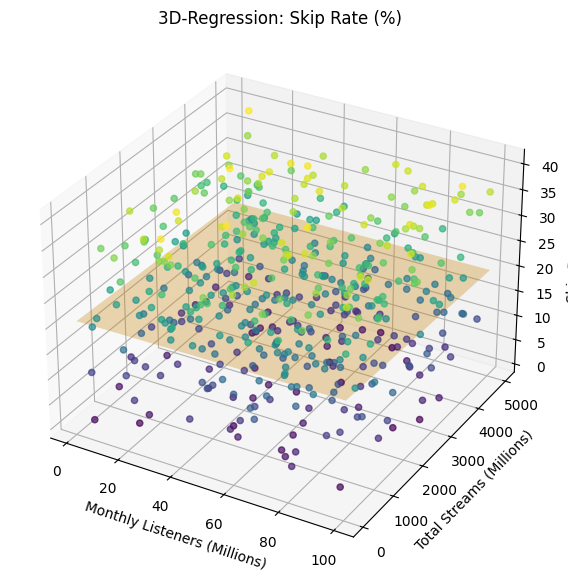

In [63]:
# Zwei Features auswählen
feat1 = "Monthly Listeners (Millions)"
feat2 = "Total Streams (Millions)"

# Werte für Plot extrahieren
xs = df[feat1]
ys = df[feat2]
zs = df["Skip Rate (%)"]

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs, c=zs, cmap='viridis', alpha=0.7)

# Regressionsebene berechnen
X_plane = df[[feat1, feat2]]
y_plane = df["Skip Rate (%)"]
model3d = LinearRegression().fit(X_plane, y_plane)

# Gitter für die Ebene erzeugen
x_surf, y_surf = np.meshgrid(
    np.linspace(xs.min(), xs.max(), 20),
    np.linspace(ys.min(), ys.max(), 20)
)
z_surf = model3d.intercept_ + model3d.coef_[0]*x_surf + model3d.coef_[1]*y_surf

ax.plot_surface(x_surf, y_surf, z_surf, alpha=0.3, color='orange')

ax.set_xlabel(feat1)
ax.set_ylabel(feat2)
ax.set_zlabel('Skip Rate (%)')
plt.title("3D-Regression: Skip Rate (%)")
plt.show()

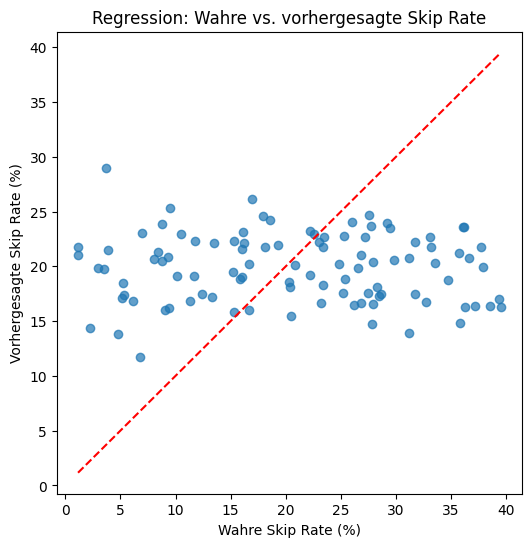

In [64]:
plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel("Wahre Skip Rate (%)")
plt.ylabel("Vorhergesagte Skip Rate (%)")
plt.title("Regression: Wahre vs. vorhergesagte Skip Rate")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.show()